In [1]:
from SimulationDataset import *

import matplotlib.pyplot as mpl
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

Examine the spatial distribution of detector hits, if they cross the full detector from the origin crystal Lu decay

In [2]:
def ReadBackground( crystalData ):
    
    z = []
    phi = []
    energyNearSide = []
    energyFarSide = []
    for dataset in crystalData:
        for i in range( dataset.size() ):
            event = dataset.SampleOneEvent()
            for hit in event:
                phiVal = hit[4]
            
                # Ensure it's not a decay in the same crystal
                if math.fabs( phiVal ) > math.pi / 4.0:
                    z.append( hit[5] )
                    energyFarSide.append( hit[1] )
                
                    # Rotate to opposite side centred
                    phiVal -= math.pi
                    if phiVal < -math.pi:
                        phiVal += 2.0 * math.pi
                    phi.append( phiVal )
                    
                else:
                    energyNearSide.append( hit[1] )
                    
    return energyNearSide, energyFarSide, z, phi

def Make2DHistForAttenuation( energy, z, phi ):

    print( "Detector-crossing hits: ", len(z) )
    hist = mpl.hist2d( z, phi, bins=[11,22], range=[[-550,550], [-math.pi,math.pi]], weights=energy )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Axial coordinate [mm]" )
    mpl.ylabel( "Phi coordinate [radians]")
    mpl.show()

Re-using previous simulation
8619900.0 events loaded (10000000 simulated) with average 1.1199657768651607 hits/event
Detector-crossing hits:  30284


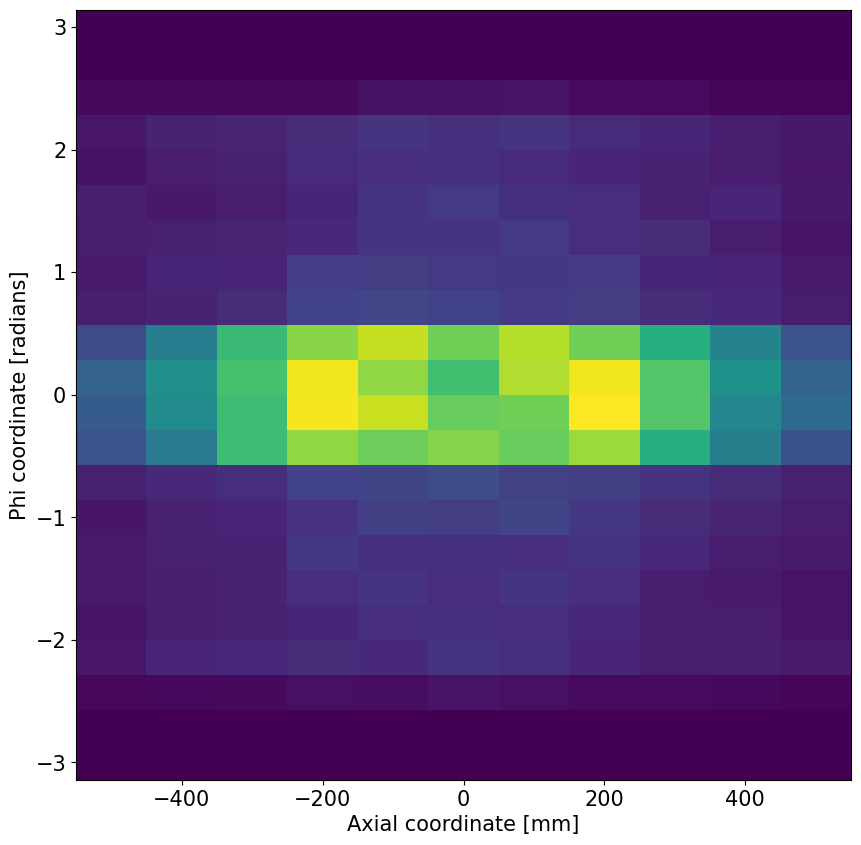

In [21]:
# Longish detector with a short PET phantom in the middle
datasetSize = 10000000
detectorLength = 1100
phantomLength = 100

crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", datasetSize, 100.0, 900.0 )
eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Examine the energy spectrum deposited in the orginal crystal, and in those across the detector

Total hits:  9623709


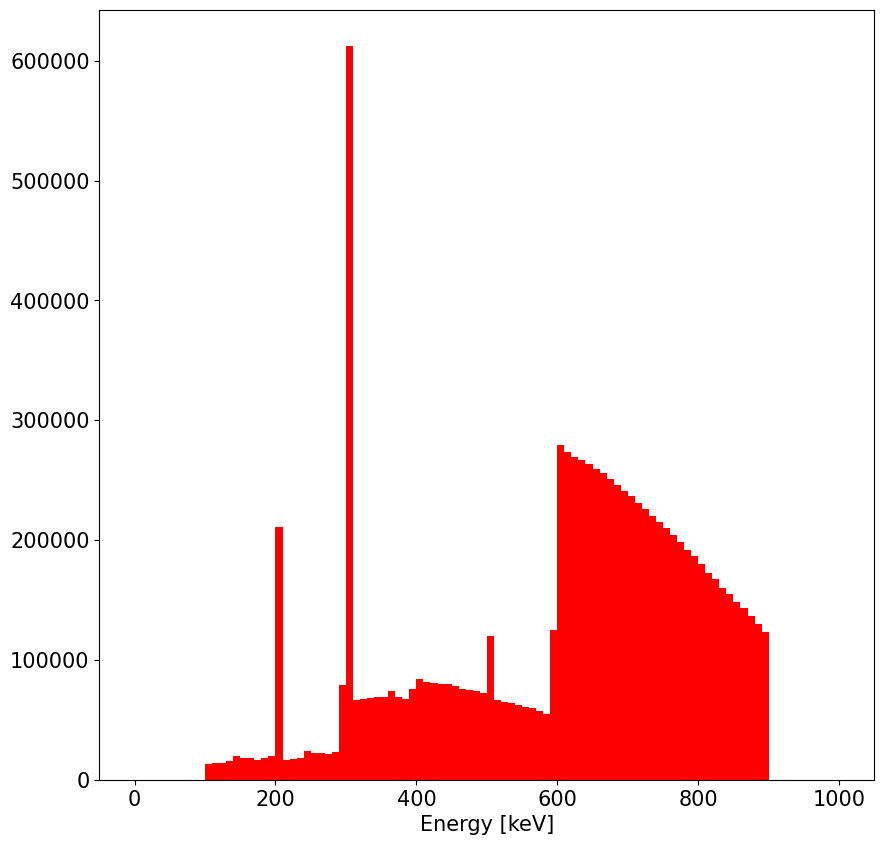

Total hits:  30284


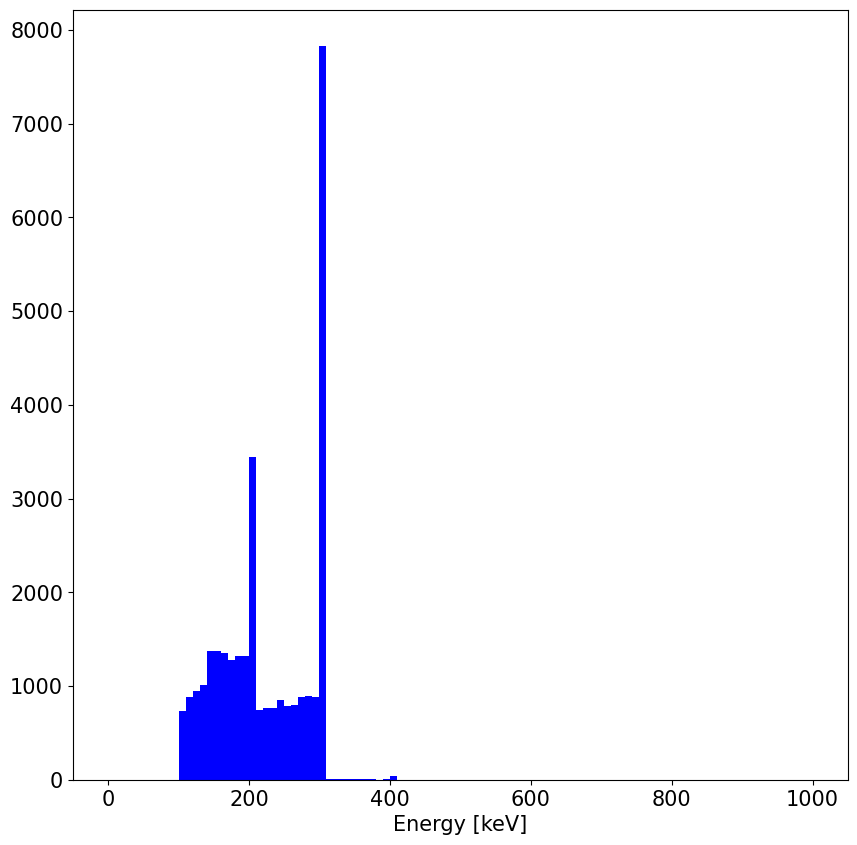

In [22]:
def MakeEnergyHist( energy, colour ):
                
    print( "Total hits: ", len(energy) )
    hist = mpl.hist( energy, bins=100, range=[0,1000], color=colour )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Energy [keV]" )
    mpl.show()

MakeEnergyHist( eNear, "r" )
MakeEnergyHist( eFar, "b" )

Photons that cross the detector do leave a visible attenuation pattern from the phantom. However, the energy captured in the crystal with the original decay is very much larger (from many more hits, with higher energy deposition), so need to specifically identify those events where a photon crossed the detector - can't rely on the simulated setup where one hit is always at phi=0

Try identifying detector-crossing photons using two-hit coincidences (local decay, and emitted photon)

Note that the energy spectrum of the detector-crossing photons is outside the range typically used for a clinical PET scan

In [5]:
import SiemensQuadraProperties as sqp

def ReadBackgroundCoincidences( crystalData, eMin=0.0, eMax=0.0 ):
    
    z = []
    phi = []
    energy = []
    for dataset in crystalData:
        for i in range( dataset.size() ):
            event = dataset.SampleOneEvent()
            
            if TwoHitEvent( event, sqp.DetectorRadius() ):
                for hit in event:
                    eVal = hit[1]
                    
                    if eMin == eMax or ( eVal <= eMax and eVal >= eMin ):
                    
                        phiVal = hit[4]
                        phiVal -= math.pi
                        if phiVal < -math.pi:
                            phiVal += 2.0 * math.pi
                        phi.append( phiVal )

                        z.append( hit[5] )

                        energy.append( eVal )
                    
    return energy, z, phi

def EnergyProfileHistogram( energy, z, phi, ylabel="Deposited energy [keV]" ):
    
    print( "Total hits: ", len(energy) )
    eNear = []
    zNear = []
    eFar = []
    zFar = []
    
    for i, pVal in enumerate(phi):
        eVal = energy[i]
        zVal = z[i]
        
        if math.fabs(pVal) < math.pi/2.0:
            eFar.append(eVal)
            zFar.append(zVal)
        else:
            eNear.append(eVal)
            zNear.append(zVal)
    
    yNear, xNear, dummy = mpl.hist( zNear, bins=22, range=[-550,550], weights=eNear )
    yFar, xFar, dummy = mpl.hist( zFar, bins=22, range=[-550,550], weights=eFar )
    mpl.clf()
    
    xBins = []
    for i, low in enumerate(xNear):
        if i + 1 < len(xNear):
            xBins.append( ( low + xNear[i+1] ) / 2.0 )
    
    mpl.plot( xBins, yNear, color="r", label="Near side" )
    mpl.plot( xBins, yFar, color="b", label="Far side" )
    mpl.gcf().set_size_inches(10, 10)
    mpl.xlabel( "Axial coordinate [mm]" )
    mpl.ylabel( "Total deposited energy [keV]" )
    mpl.legend( ["Near side", "Far side"] )
    mpl.show()
    
def HitProfileHistogram( z, phi ):
    return EnergyProfileHistogram( [1.0]*len(z), z, phi, ylabel="Total hits" )

Counting only hit coincidences, as we would for a PET image, shows a clear attenuation 

Total hits:  32314


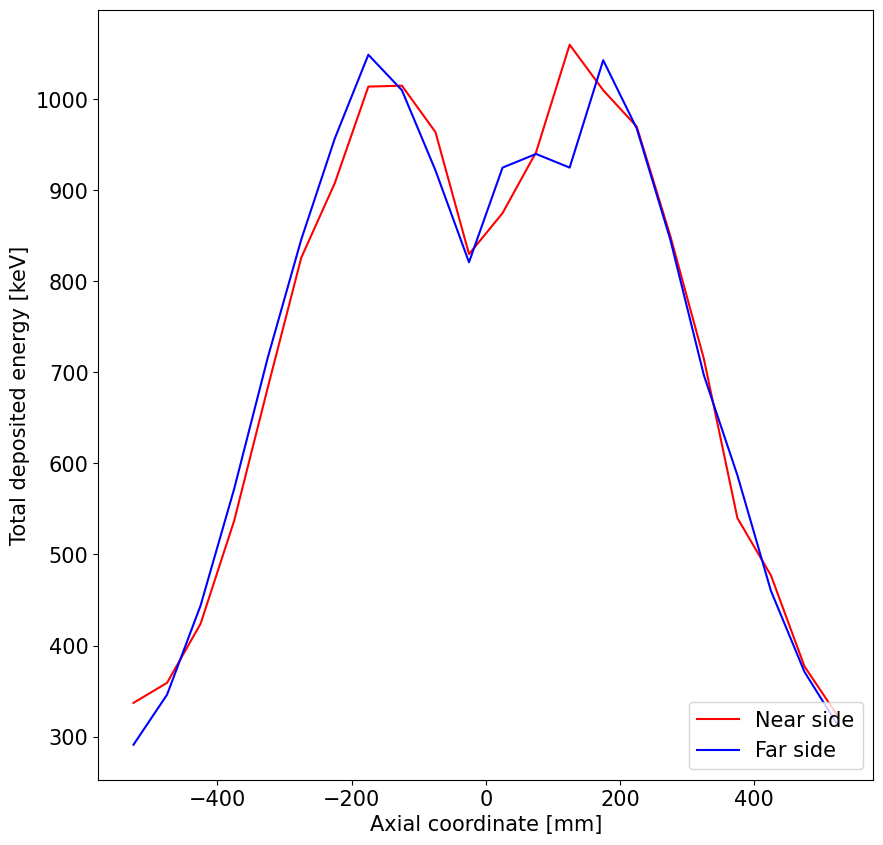

In [6]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Repeating the plot with hits weighted by energy shows the clear difference between near and far side hits, but this is probably a feature of the nuclear decay rather than attenuation in the phantom

Total hits:  32314


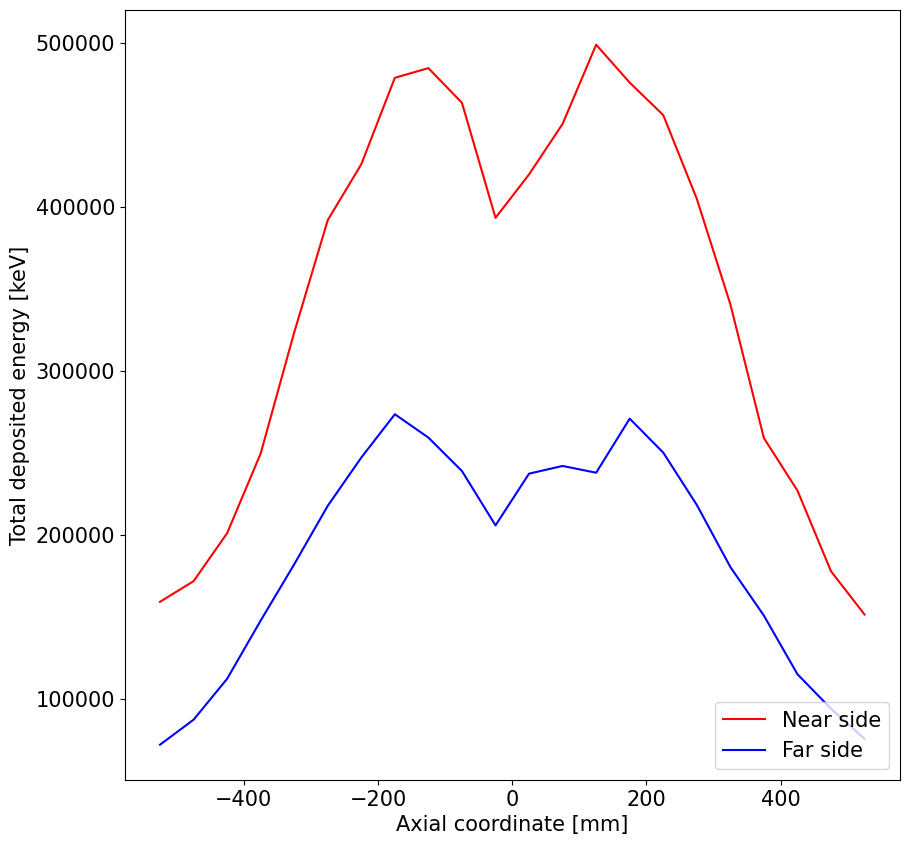

In [7]:
EnergyProfileHistogram( energy, z, phi )

Repeat for different length phantoms

Re-using previous simulation
3815969.0 events loaded (10000000 simulated) with average 1.118558615125018 hits/event
Detector-crossing hits:  9168


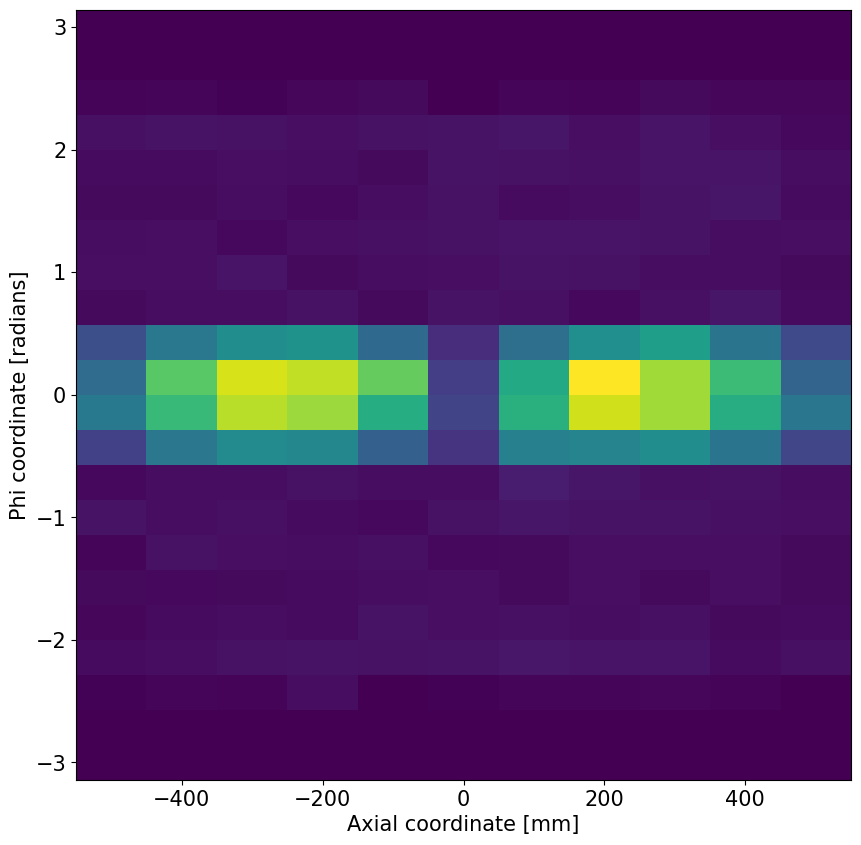

In [8]:
crystalData = CreateDataset( detectorLength, "Siemens", 1, "Siemens", datasetSize, 100.0, 900.0 )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  13132


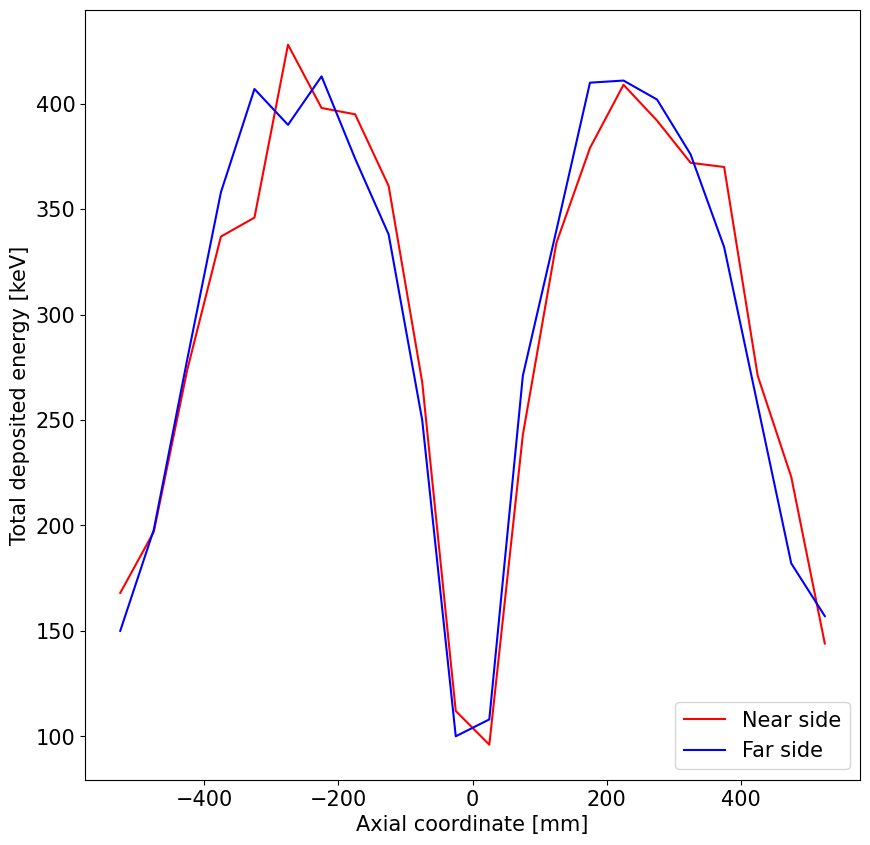

In [9]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  13132


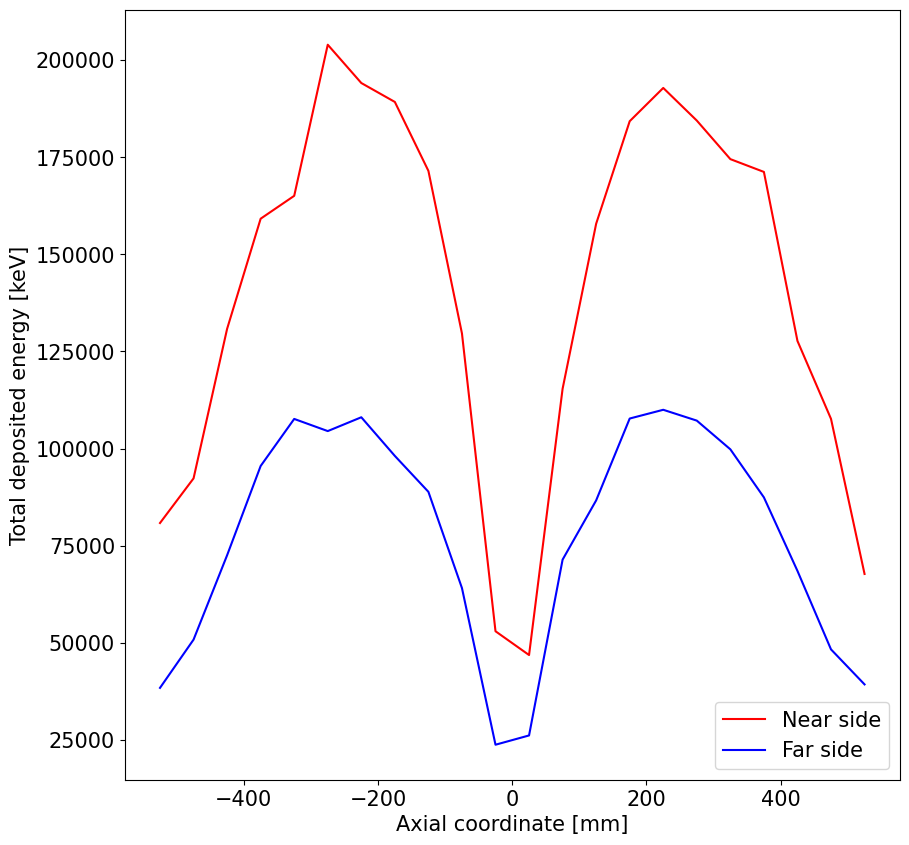

In [10]:
EnergyProfileHistogram( energy, z, phi )

Re-using previous simulation
3817882.0 events loaded (10000000 simulated) with average 1.122870481591626 hits/event
Detector-crossing hits:  21839


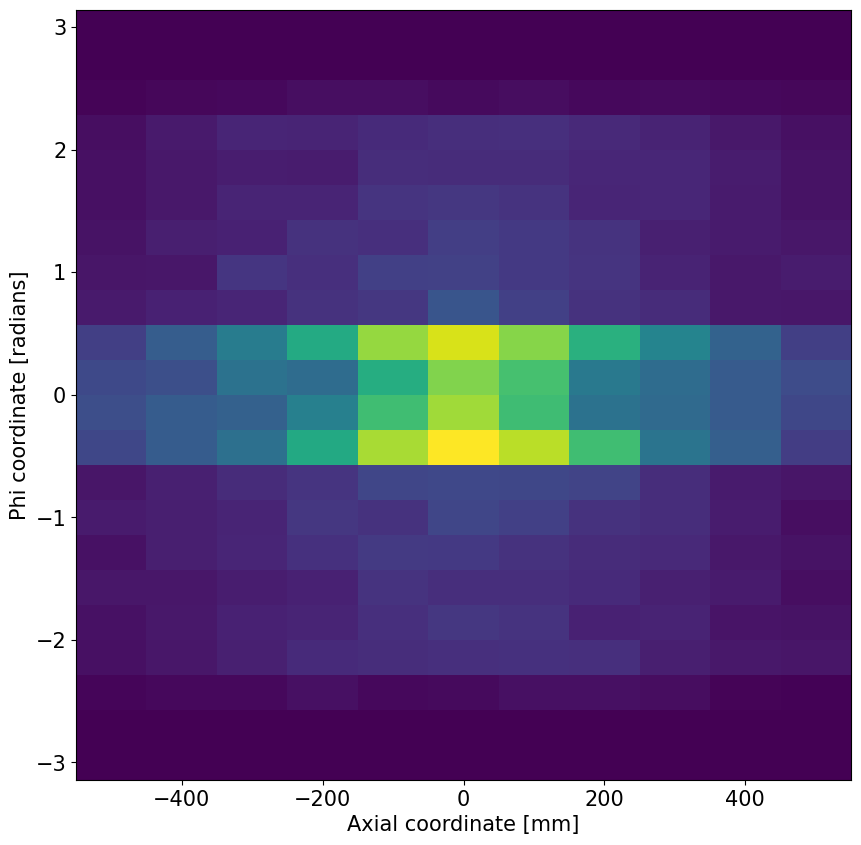

In [11]:
crystalData = CreateDataset( detectorLength, "Siemens", 300, "Siemens", datasetSize, 100.0, 900.0 )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  20858


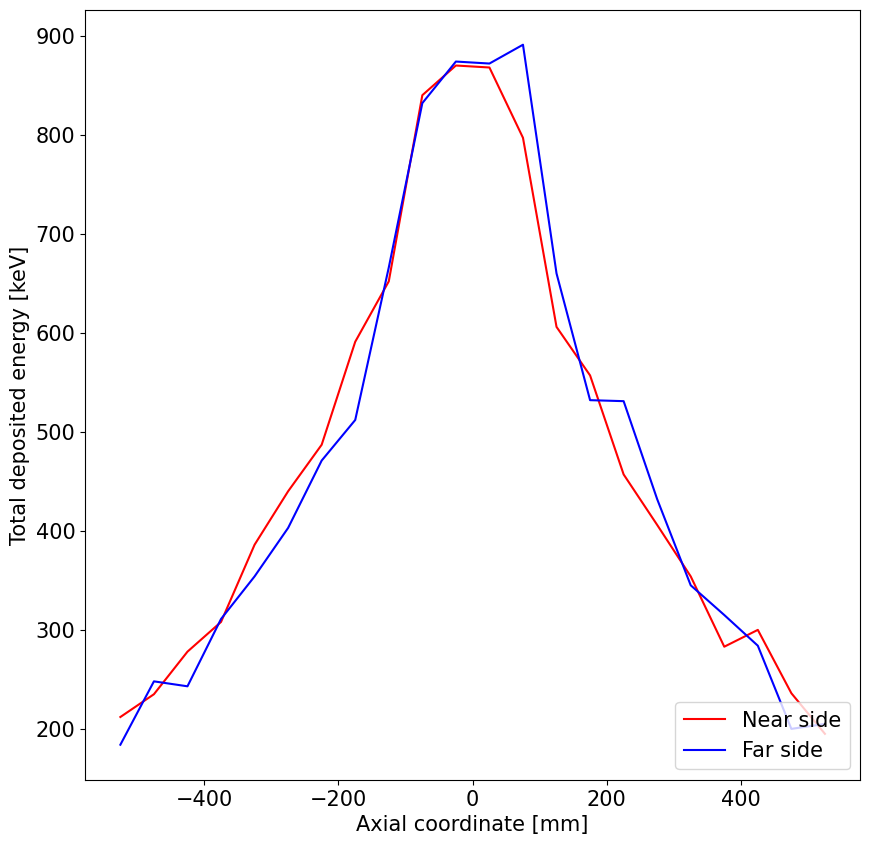

In [12]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  20858


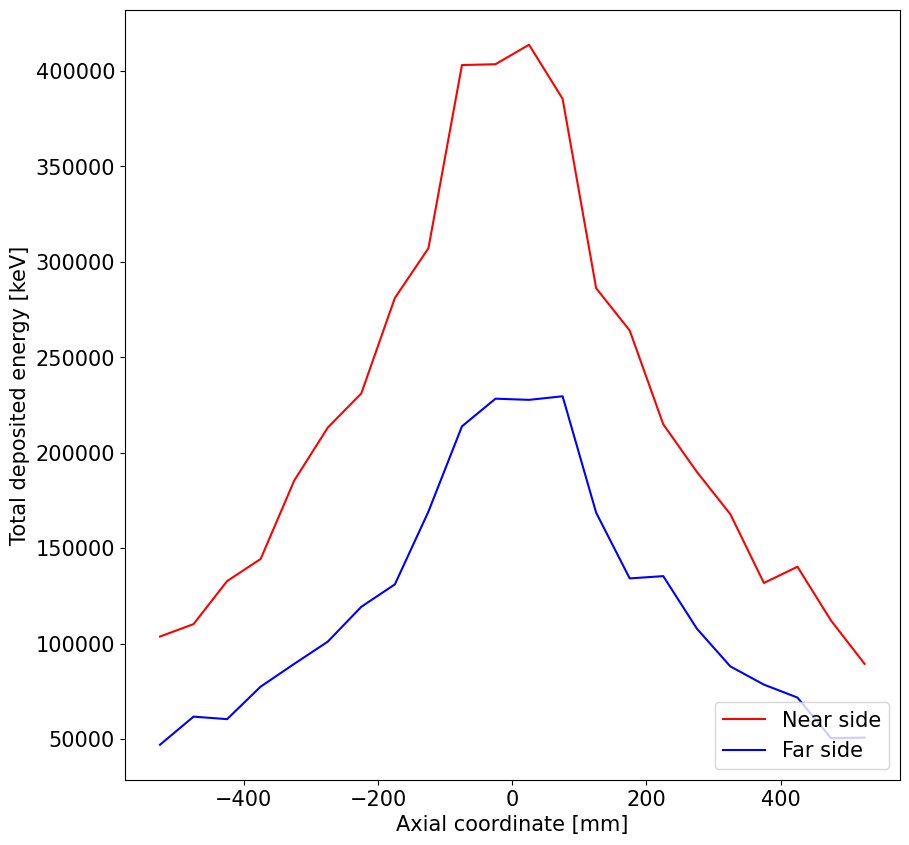

In [13]:
EnergyProfileHistogram( energy, z, phi )

Re-using previous simulation
3816522.0 events loaded (10000000 simulated) with average 1.127967033859624 hits/event
Detector-crossing hits:  36223


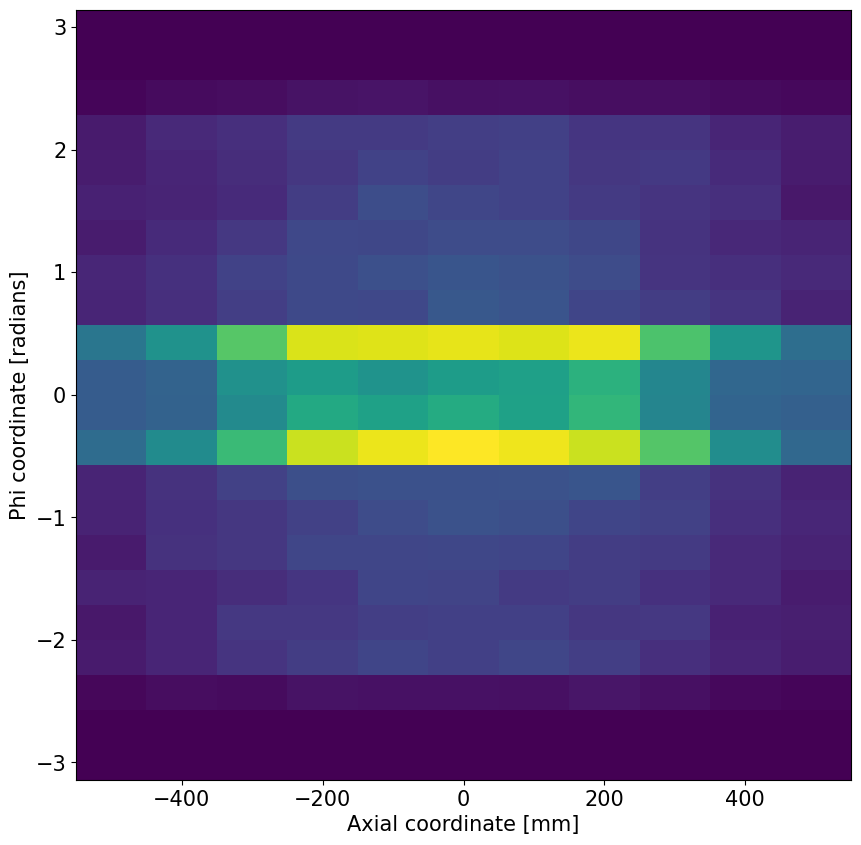

In [14]:
crystalData = CreateDataset( detectorLength, "Siemens", 700, "Siemens", datasetSize, 100.0, 900.0 )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  31554


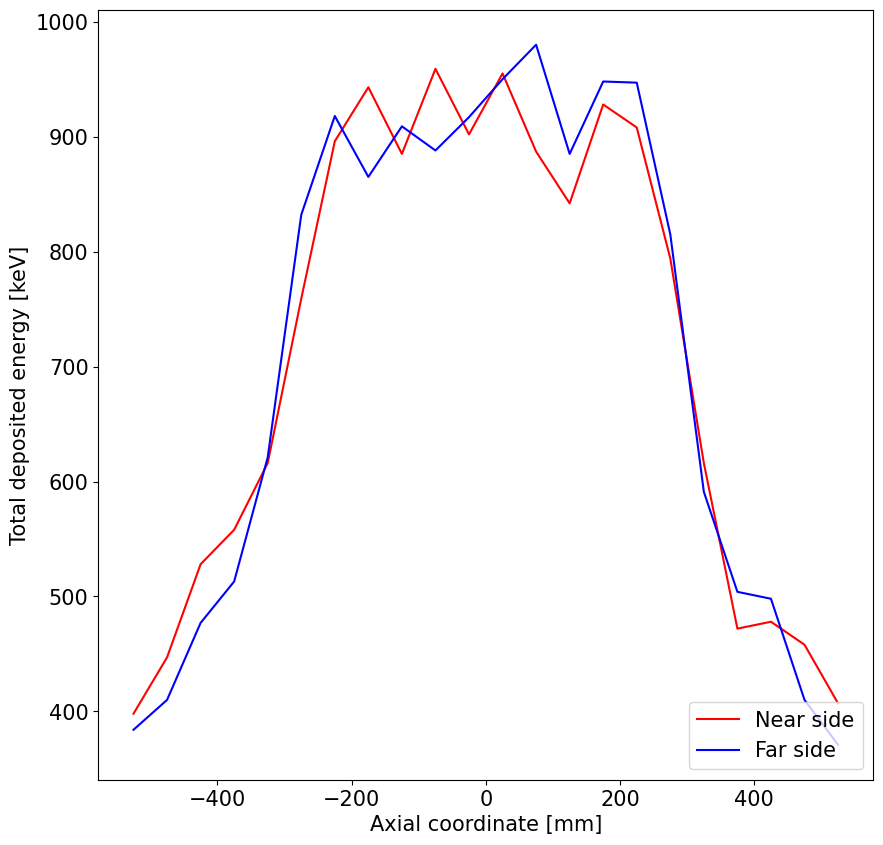

In [15]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  31554


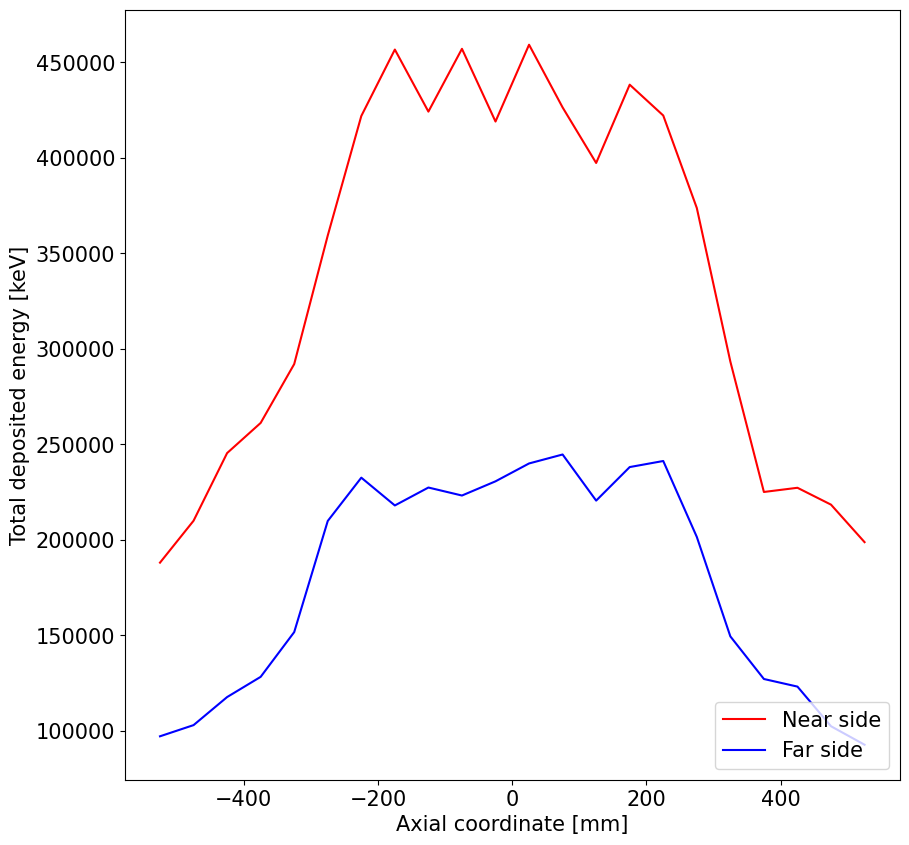

In [16]:
EnergyProfileHistogram( energy, z, phi )

Re-using previous simulation
3815990.0 events loaded (10000000 simulated) with average 1.1168821197120538 hits/event
Detector-crossing hits:  2758


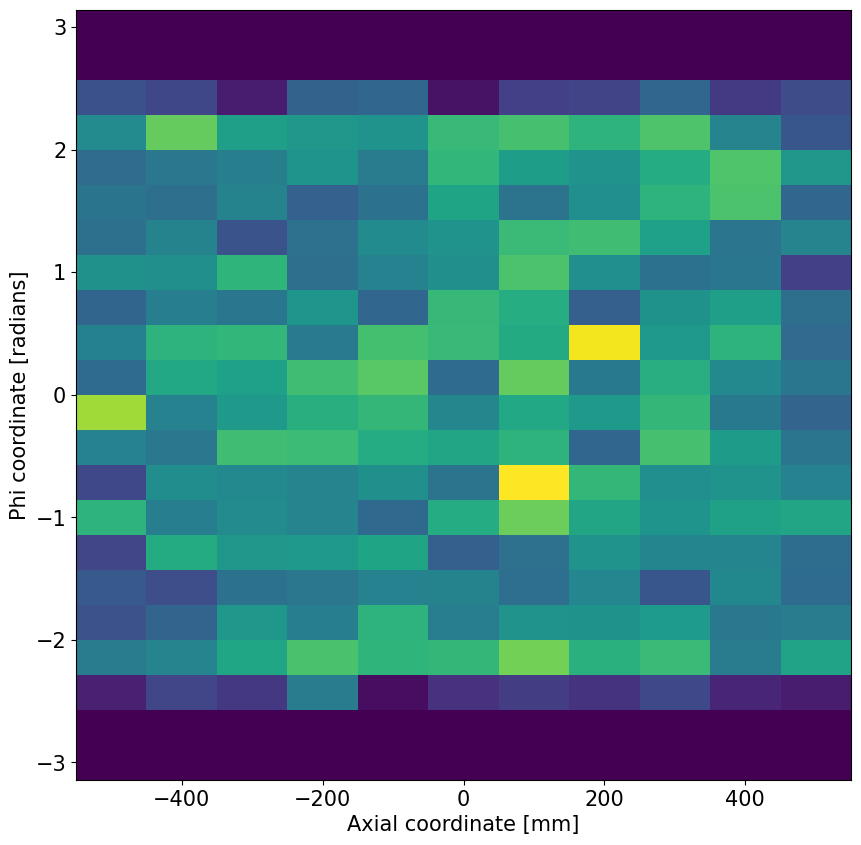

In [17]:
crystalData = CreateDataset( detectorLength, "Siemens", 0, "Siemens", datasetSize, 100.0, 900.0 )

eNear, eFar, z, phi = ReadBackground( [crystalData] )
Make2DHistForAttenuation( eFar, z, phi )

Total hits:  1348


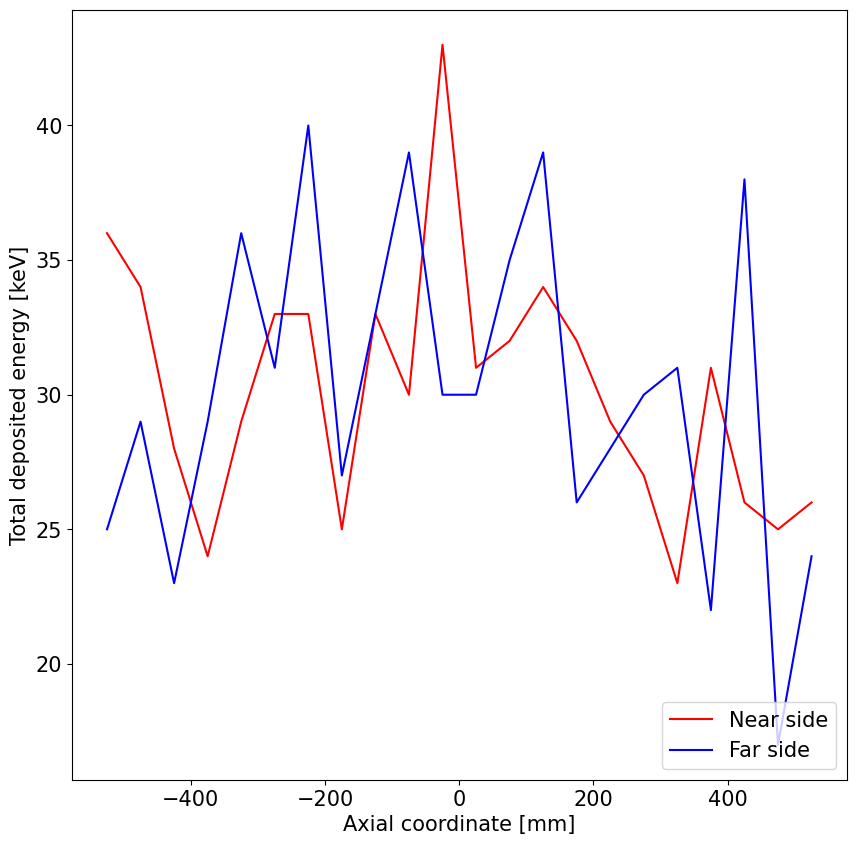

In [18]:
energy, z, phi = ReadBackgroundCoincidences( [crystalData] )
HitProfileHistogram( z, phi )

Total hits:  1348


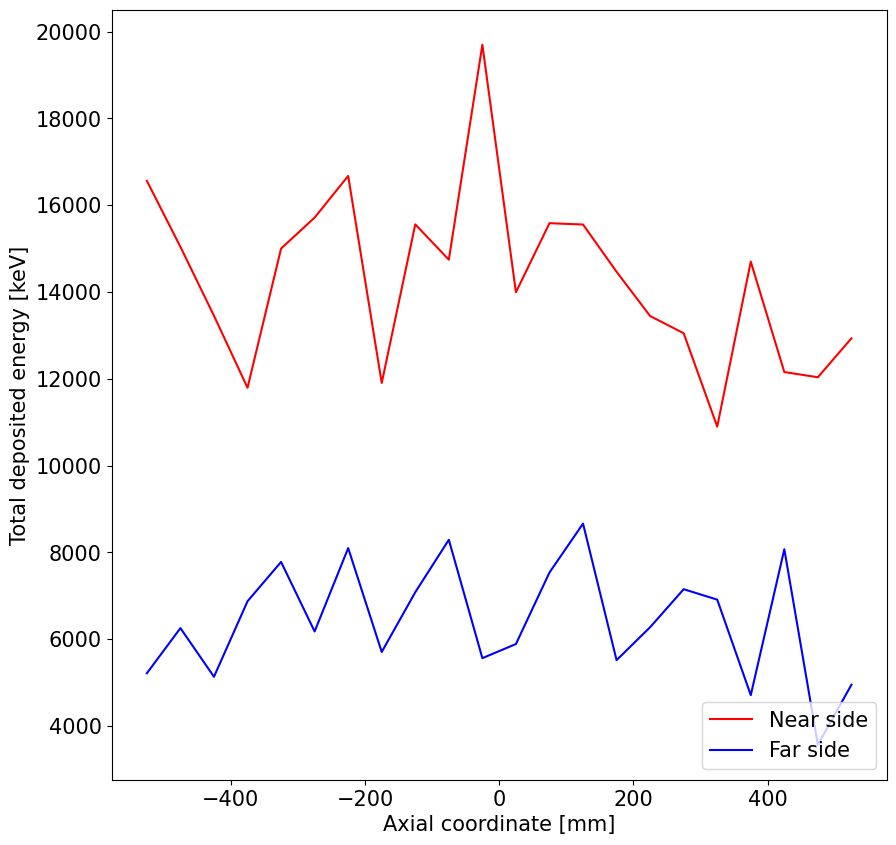

In [19]:
EnergyProfileHistogram( energy, z, phi )